Deadline: 2022-04-18 9:00 AM GMT+3

Competition: https://github.com/dialogue-evaluation/RuREBus

CRF: https://pytorch.org/tutorials/beginner/nlp/advanced_tutorial.html

### NER: CharCNN-BiLSTM-CRF

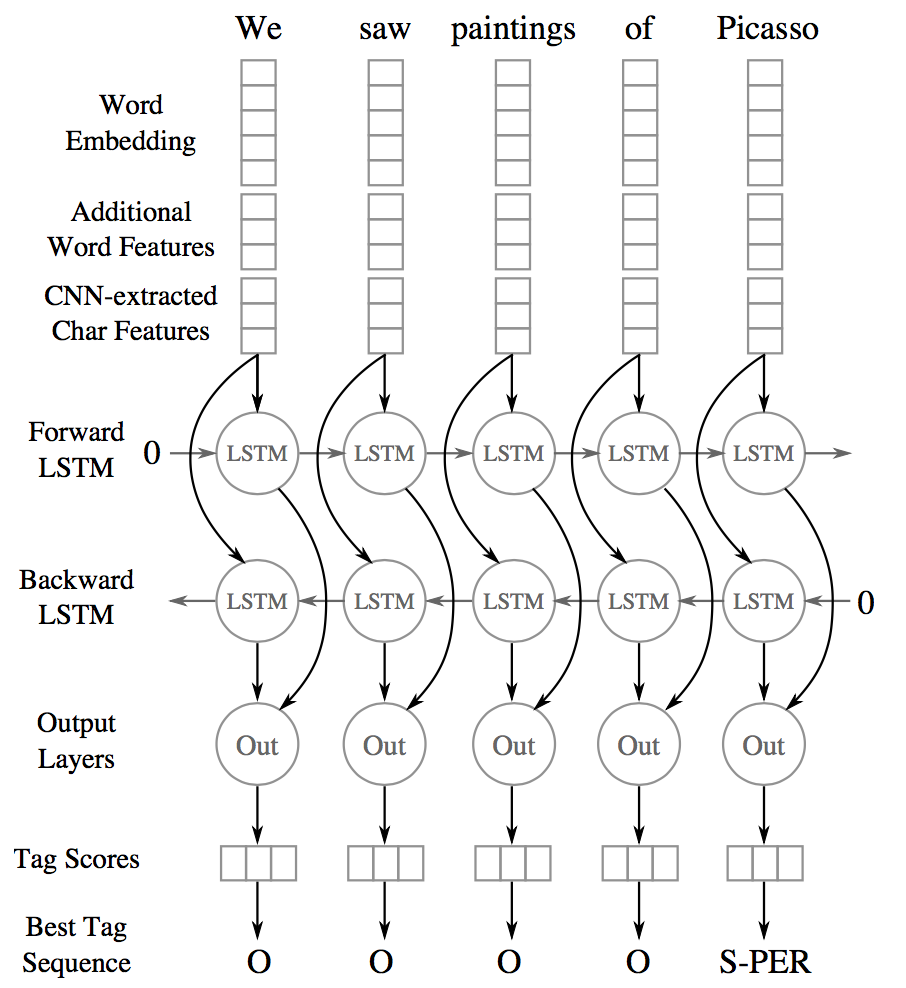

### Get data

In [1]:
%%capture
!wget https://raw.githubusercontent.com/dialogue-evaluation/RuREBus/master/eval_scripts/brat_format.py
!wget https://raw.githubusercontent.com/dialogue-evaluation/RuREBus/master/eval_scripts/evaluate_ners.py
!wget https://github.com/dialogue-evaluation/RuREBus/raw/master/train_data/train_part_1.zip
!wget https://github.com/dialogue-evaluation/RuREBus/raw/master/train_data/train_part_2.zip
!wget https://github.com/dialogue-evaluation/RuREBus/raw/master/train_data/train_part_3.zip
!wget https://github.com/dialogue-evaluation/RuREBus/raw/master/test_data/test_ner_only.zip
!unzip -qq /content/train_part_1.zip
!unzip -qq /content/train_part_2.zip
!unzip -qq /content/train_part_3.zip
!unzip -qq /content/test_ner_only.zip -d /content/test
!pip install razdel
!pip install pytorch_lightning
!pip install transformers

In [2]:
path_list = ['/content/train_part_1', '/content/train_part_2', '/content/train_part_3']

In [3]:
import os
from os import listdir
from os.path import isfile, join
from tqdm import tqdm

In [4]:
# get markup
data = []
for path in path_list:
    files = [f for f in listdir(path) if isfile(join(path, f))]
    # get .txt and .ann files in dir
    files = [f for f in files if f[-3:] in ['ann', 'txt']]
    # get names
    names = list(set([f[:-4] for f in files]))
    for name in names:
        cpath = path + '/' + name
        with open(cpath + '.ann') as f:
            markup = f.readlines()
        with open(cpath + '.txt') as f:
            text = f.read()
        markup_list = []
        for line in markup:
            parts = line.split()
            if parts[0][0] == 'T':
                markup_list.append(tuple([int(parts[2])] + [int(parts[3])] + [parts[1]] + [text[int(parts[2]):int(parts[3])]]))
        data.append((text, markup_list, name))

In [5]:
data_test = []
path = '/content/test'
files = [f for f in listdir(path) if isfile(join(path, f))]
# get .txt and .ann files in dir
files = [f for f in files if f[-3:] in ['ann', 'txt']]
# get names
names = list(set([f[:-4] for f in files]))
for name in names:
    cpath = path + '/' + name
    with open(cpath + '.ann') as f:
        markup = f.readlines()
    with open(cpath + '.txt') as f:
        text = f.read()
    markup_list = []
    for line in markup:
        parts = line.split()
        if parts[0][0] == 'T':
            markup_list.append(tuple([int(parts[2])] + [int(parts[3])] + [parts[1]] + [text[int(parts[2]):int(parts[3])]]))
    data_test.append((text, markup_list, name))

### BIO

In [6]:
# get span types
spans = []
for doc in data:
    for span in doc[1]:
        spans.append(span[2])

In [7]:
span_types = list(set(spans))

In [8]:
span_types

['CMP', 'ACT', 'ECO', 'BIN', 'MET', 'SOC', 'INST', 'QUA']

In [9]:
labels_dict = {
    'OUTER': 0,
    'ECO_BEGIN': 1,
    'ECO_INNER': 2,
    'BIN_BEGIN': 3,
    'BIN_INNER': 4,
    'ACT_BEGIN': 5,
    'ACT_INNER': 6,
    'SOC_BEGIN': 7,
    'SOC_INNER': 8,
    'INST_BEGIN': 9,
    'INST_INNER': 10,
    'CMP_BEGIN': 11,
    'CMP_INNER': 12,
    'MET_BEGIN': 13,
    'MET_INNER': 14,
    'QUA_BEGIN': 15,
    'QUA_INNER': 16
}

In [10]:
from collections import namedtuple
from razdel import tokenize

In [11]:
Sample = namedtuple("Sample", "text,tokens,spans,labels,name")

In [12]:
def text_span_to_sample(text, spans, name):
    labels = []
    tokens = list(tokenize(text))
    for token in tokens:
        label = labels_dict['OUTER']
        for span in spans:
            span_begin, span_end, tag, _ = span
            if token.start == span_begin:
                label = labels_dict[tag + '_BEGIN']
            elif token.start > int(span_begin) and token.stop <= int(span_end):
                label = labels_dict[tag + '_INNER']           
        labels.append(label)
    sample = Sample(text, tokens, spans, labels, name)
    return sample

In [13]:
from tqdm import tqdm

In [14]:
samples = []
for text, spans, name in tqdm(data):
    samples.append(text_span_to_sample(text, spans, name))

100%|██████████| 188/188 [01:18<00:00,  2.39it/s]


In [15]:
test = []
for text, spans, name in tqdm(data_test):
    test.append(text_span_to_sample(text, spans, name))

100%|██████████| 544/544 [01:12<00:00,  7.50it/s]


In [16]:
len(samples) * 0.8

150.4

In [17]:
import random
random.shuffle(samples)

train = samples[:150]
val = samples[150:]

In [18]:
char_set = ["<pad>", "<unk>"] + list({ch for sample in train for token in sample.tokens for ch in token.text})
print(char_set)

['<pad>', '<unk>', 'д', 'к', 'k', '\uf0b7', 'a', 'A', '┬', 'Ё', 'Ч', 'K', 'f', 'b', '}', 'Ö', 'Ы', 'H', 'ц', 'w', 'ч', 'Й', 'j', 'Л', '∑', 'z', 'з', 'І', 'C', '-', 'R', 'т', '–', ';', 'ё', '├', 'd', 'Ж', 'ф', '/', '_', 'S', 'с', '«', 'Ф', 'n', 'Щ', '%', '=', 'У', 'Z', 'y', 'p', '■', '+', 'И', '"', 'ж', 'I', '{', 'ш', '<', 'h', '•', '6', 'D', '!', '2', 'ю', '4', 'г', 'ә', 'Ь', 'а', 'Ъ', 'X', 'п', '…', 'L', 'v', '—', '»', 'Ш', 'и', 'T', 'B', '*', 'А', '─', 'э', '£', 'x', '@', 'N', '│', 'Ю', '┌', 'E', 'н', ',', 'В', 'U', '“', 'Σ', ':', 'W', 'o', 'Т', 'l', 't', 'r', 'm', 'c', 'М', 'р', 'я', '┼', 'у', 'e', 'о', '№', 'P', 'Ә', 'щ', 'Э', 'в', '0', 'V', '8', '.', '7', 'u', 'Р', 'Н', 'F', 'Х', '5', 's', 'Д', 'Е', 'M', 'б', 'П', '×', 'ь', 'ы', 'О', '1', '”', 'Б', 'Ц', '‰', 'х', 'g', 'л', '>', ')', 'й', 'Г', 'O', 'З', '9', 'К', 'С', 'е', 'м', 'җ', 'Я', 'ъ', '3', '(', 'G', 'i']


In [19]:
# get max seq len
len_list = []
for text, _, _ in tqdm(data):
    len_list.append(len(list(tokenize(text))))

100%|██████████| 188/188 [00:03<00:00, 51.23it/s]


In [20]:
max(len_list)

8945

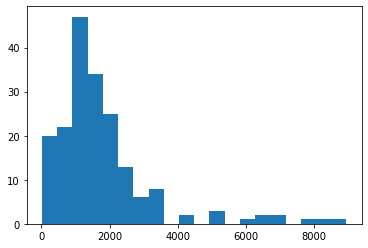

In [21]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

plt.hist(len_list, density=False, bins=20)
plt.show()

In [22]:
word_set = ["<unk>"] + list({token.text for sample in train for token in sample.tokens})

### DataSet

In [23]:
import torch
from torch.utils.data import Dataset
from torch.utils.data import DataLoader, RandomSampler

In [24]:
class NerCharsDataset(Dataset):
    def __init__(self, samples, char_set, word_set, max_seq_len=4096, max_char_seq_len=16):
        assert len(samples) != 0
        self.samples = []
        self.tokens = []
        self.texts = []
        self.names = []
        for sample in samples:
            inputs = torch.zeros((max_seq_len, max_char_seq_len), dtype=torch.long)
            words = torch.zeros(max_seq_len, dtype=torch.long)
            for token_num, token in enumerate(sample.tokens[:max_seq_len]):
                word = token.text
                word_index = word_set.index(word) if word in word_set else word_set.index("<unk>")
                words[token_num] = word_index
                for ch_num, ch in enumerate(token.text[:max_char_seq_len]):
                    char_index = char_set.index(ch) if ch in char_set else char_set.index("<unk>")
                    inputs[token_num][ch_num] = char_index
            labels = torch.zeros((max_seq_len,), dtype=torch.long)
            input_labels = [int(i) for i in sample.labels[:max_seq_len]]
            labels[:len(input_labels)] = torch.LongTensor(input_labels)
            self.samples.append(
                    (torch.LongTensor(words), torch.LongTensor(inputs), torch.LongTensor(labels))
                )
            self.tokens.append(sample.tokens[:max_seq_len])
            self.texts.append(sample.text)
            self.names.append(sample.name)
    
    def __len__(self):
        return len(self.samples)
    
    def __getitem__(self, index):
        return self.samples[index]

    def get_tokens(self, index):
        return self.tokens[index]
    
    def get_text(self, index):
        return self.texts[index]

    def get_name(self, index):
        return self.names[index]

In [25]:
BATCH_SIZE = 2

train_data = NerCharsDataset(train, char_set, word_set)
train_sampler = RandomSampler(train_data)
train_loader = DataLoader(train_data, batch_size=BATCH_SIZE, sampler=train_sampler)

val_data = NerCharsDataset(val, char_set, word_set)
val_loader = DataLoader(val_data, batch_size=BATCH_SIZE)

test_data = NerCharsDataset(test, char_set, word_set)
test_loader = DataLoader(test_data, batch_size=BATCH_SIZE)

In [26]:
for sample in train_data:
    break

In [27]:
words, chars, labels = sample

In [28]:
print(words.shape)
print(chars.shape)
print(labels.shape)

torch.Size([4096])
torch.Size([4096, 16])
torch.Size([4096])


### Model

In [29]:
import torch
import torch.nn as nn
from pytorch_lightning import LightningModule
from torchmetrics import Accuracy

In [30]:
class TemplateModel(LightningModule):
    def __init__(self):
        super().__init__()
        
        self.loss = nn.CrossEntropyLoss()
        self.valid_accuracy = Accuracy()
        self.test_accuracy = Accuracy()
    
    def forward(self, words, chars, labels):
        raise NotImplementedError("forward not implemented")
    
    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=1e-3)
        return optimizer
    
    def training_step(self, batch, _):
        words, chars, labels = batch
        loss, logits = self(words, chars, labels)
        return loss
    
    def validation_step(self, batch, _):
        words, chars, labels = batch
        val_loss, logits = self(words, chars, labels)
        self.valid_accuracy.update(logits, labels)
        self.log("val_loss", val_loss, prog_bar=True)
        self.log("val_acc", self.valid_accuracy)

    def validation_epoch_end(self, outs):
        self.log("val_acc_epoch", self.valid_accuracy.compute(), prog_bar=True)

    def test_step(self, batch, _):
        words, chars, labels = batch
        test_loss, logits = self(words, chars, labels)
        self.test_accuracy.update(logits, labels)
        self.log("test_loss", test_loss, prog_bar=True)
        self.log("test_acc", self.test_accuracy)

    def test_epoch_end(self, outs):
        self.log("test_acc_epoch", self.test_accuracy.compute(), prog_bar=True)

### Helper

In [31]:
def get_entities_list(text, labels):
    entities_list = []
    current_entity = {
        'num': '',
        'tag': '',
        'start': 0,
        'stop': 0,
        'text': 0
    }
    
    tokens = list(tokenize(text))
    if len(tokens) > len(labels):
        tokens = tokens[:len(labels)]
    else:
        labels = labels[:len(tokens)]

    for token, label in zip(tokens, labels):
        if label > 0:
            tag = list(labels_dict.keys())[list(labels_dict.values()).index(label)].split('_')[0]
            pos = list(labels_dict.keys())[list(labels_dict.values()).index(label)].split('_')[1]       
            if pos == 'BEGIN':
                current_entity['num'] = 'T' + str(len(entities_list) + 1)
                current_entity['tag'] = tag
                current_entity['start'] = token.start
                current_entity['stop'] = token.stop
                current_entity['text'] = text[int(current_entity['start']):int(current_entity['stop'])]
                entities_list.append(current_entity.copy())
            else:
                current_entity = entities_list[-1].copy()
                if current_entity['tag'] == tag:
                    current_entity['stop'] = token.stop
                    current_entity['text'] = text[int(current_entity['start']):int(current_entity['stop'])]
                    entities_list[-1] = current_entity.copy()
    return entities_list

### Predict

In [32]:
def predict(model, device, data, path):
    try:
        os.mkdir(path)
    except:
        pass
    for i, sample in tqdm(enumerate(data)):
        text = data.get_text(i)
        name = data.get_name(i)
        tokens = data.get_tokens(i)
        words = torch.unsqueeze(sample[0], 0)
        chars = torch.unsqueeze(sample[1], 0)
        labels = torch.unsqueeze(sample[2], 0)
        _, logits = model(words.to(device), chars.to(device), labels.to(device))
        predicted_labels = logits.max(dim=1)[1].detach().cpu().numpy()
        # Remove BIO inconsistency
        for sample_num, sample in enumerate(predicted_labels):
            for token_num, label in enumerate(sample):
                if token_num == 0 and (label % 2 ) == 0 and label != 0:
                    predicted_labels[sample_num][0] = label - 1
                    continue
                prev_label = sample[token_num - 1]
                if (label % 2) == 0 and prev_label == 0 and label != 0:
                    predicted_labels[sample_num][token_num] = label - 1

        predicted_labels = predicted_labels[0].tolist()
        entities_list = get_entities_list(text, predicted_labels)
        ann_list = []
        
        for entity in entities_list:
            ann_list.append(entity['num'] + '\t' + entity['tag'] + ' ' + str(entity['start']) + ' ' + str(entity['stop']) + '\t' + entity['text'])
        
        with open(path + name + '.ann', 'w') as f:
            for item in ann_list:
                f.write("%s\n" % item)

### Metrics

In [33]:
from brat_format import read_file

In [34]:
from evaluate_ners import calc_ner_f1

### Device

In [35]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [36]:
import torch
from torch import nn
from pytorch_lightning import Trainer
from pytorch_lightning.callbacks import EarlyStopping

### Word-level CNN

In [37]:
class CharCNNLstmModel(TemplateModel):


    def __init__(
            self,
            char_vocab_size,
            word_vocab_size,
            char_embedding_dim,
            word_embedding_dim,
            max_char_seq_len,
            max_seq_len,
            classes_count,
            hidden_dim,
            kernel_size
        ):
        super().__init__()

        self.char_vocab_size = char_vocab_size
        self.char_embedding_dim = char_embedding_dim

        self.word_vocab_size = word_vocab_size
        self.word_embedding_dim = word_embedding_dim
        self.max_char_seq_len = max_char_seq_len
        self.max_seq_len = max_seq_len
        self.classes_count = classes_count
        self.hidden_dim = hidden_dim
        self.kernel_size = kernel_size

        self.char_embeddings = nn.Embedding(self.char_vocab_size, char_embedding_dim)
        self.conv1d = nn.Conv1d(self.char_embedding_dim, 1, kernel_size=self.kernel_size)

        self.word_embeddings = nn.Embedding(word_vocab_size, word_embedding_dim)

        self.lstm = nn.LSTM(
            (self.max_char_seq_len + self.word_embedding_dim - self.kernel_size + 1),
            self.hidden_dim // 2,
            batch_first=True,
            bidirectional=True
        )

        self.hidden2tag = nn.Linear(self.hidden_dim, self.classes_count)


    def forward(self, words, chars, labels):
        batch_size = words.size(0)
        char_embeds = self.char_embeddings(chars)
        char_embeds = torch.reshape(
            char_embeds,
            (self.max_seq_len * batch_size, self.max_char_seq_len, self.char_embedding_dim)
        )
        char_embeds = char_embeds.permute(0,2,1)
        char_embeds = self.conv1d(char_embeds)
        char_embeds = torch.reshape(char_embeds, (batch_size, self.max_seq_len, -1))

        word_embeds = self.word_embeddings(words)
        embeds = torch.cat((word_embeds, char_embeds), 2)
        result, _ = self.lstm(embeds)
        result = self.hidden2tag(result)
        logits = result.transpose(1, 2)
        loss = self.loss(logits, labels)
        return loss, logits

In [38]:
char_vocab_size = len(char_set)
word_vocab_size = len(word_set)
char_embedding_dim = 8
word_embedding_dim = 64
max_char_seq_len = 16
max_seq_len = 4096
classes_count = len(labels_dict)
hidden_dim = 64
kernel_size = 3

In [39]:
char_cnn_lstm_model = CharCNNLstmModel(
            char_vocab_size=char_vocab_size,
            word_vocab_size=word_vocab_size,
            char_embedding_dim=char_embedding_dim,
            word_embedding_dim=word_embedding_dim,
            max_char_seq_len=max_char_seq_len,
            max_seq_len=max_seq_len,
            classes_count=classes_count,
            hidden_dim=hidden_dim,
            kernel_size=kernel_size
        )

In [40]:
early_stop_callback = EarlyStopping(
    monitor="val_loss",
    min_delta=0.0,
    patience=8,
    verbose=True,
    mode="min" 
)

In [41]:
trainer = Trainer(
    gpus=0,
    checkpoint_callback=False,
    accumulate_grad_batches=1,
    max_epochs=1,
    progress_bar_refresh_rate=10,
    callbacks=[early_stop_callback])

/usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/connectors/callback_connector.py:152: LightningDeprecationWarning: Setting `Trainer(checkpoint_callback=False)` is deprecated in v1.5 and will be removed in v1.7. Please consider using `Trainer(enable_checkpointing=False)`.
  f"Setting `Trainer(checkpoint_callback={checkpoint_callback})` is deprecated in v1.5 and will "
/usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/connectors/callback_connector.py:97: LightningDeprecationWarning: Setting `Trainer(progress_bar_refresh_rate=10)` is deprecated in v1.5 and will be removed in v1.7. Please pass `pytorch_lightning.callbacks.progress.TQDMProgressBar` with `refresh_rate` directly to the Trainer's `callbacks` argument instead. Or, to disable the progress bar pass `enable_progress_bar = False` to the Trainer.
  f"Setting `Trainer(progress_bar_refresh_rate={progress_bar_refresh_rate})` is deprecated in v1.5 and"
GPU available: True, used: False
TPU available: False

In [42]:
trainer.fit(char_cnn_lstm_model, train_loader, val_loader)

Missing logger folder: /content/lightning_logs

  | Name            | Type             | Params
-----------------------------------------------------
0 | loss            | CrossEntropyLoss | 0     
1 | valid_accuracy  | Accuracy         | 0     
2 | test_accuracy   | Accuracy         | 0     
3 | char_embeddings | Embedding        | 1.4 K 
4 | conv1d          | Conv1d           | 25    
5 | word_embeddings | Embedding        | 1.5 M 
6 | lstm            | LSTM             | 28.7 K
7 | hidden2tag      | Linear           | 1.1 K 
-----------------------------------------------------
1.6 M     Trainable params
0         Non-trainable params
1.6 M     Total params
6.211     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_loss improved. New best score: 0.659


In [43]:
trainer.test(char_cnn_lstm_model, test_loader)

Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.9260568022727966
     test_acc_epoch         0.9260568022727966
        test_loss           0.3723863661289215
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_acc': 0.9260568022727966,
  'test_acc_epoch': 0.9260568022727966,
  'test_loss': 0.3723863661289215}]

In [44]:
model = char_cnn_lstm_model
model.to(device)
model.eval()

CharCNNLstmModel(
  (loss): CrossEntropyLoss()
  (valid_accuracy): Accuracy()
  (test_accuracy): Accuracy()
  (char_embeddings): Embedding(173, 8)
  (conv1d): Conv1d(8, 1, kernel_size=(3,), stride=(1,))
  (word_embeddings): Embedding(23773, 64)
  (lstm): LSTM(78, 32, batch_first=True, bidirectional=True)
  (hidden2tag): Linear(in_features=64, out_features=17, bias=True)
)

In [45]:
pred_path = '/content/pred_word_lstm/'

In [46]:
predict(model, device, test_data, pred_path)

544it [02:51,  3.17it/s]


In [47]:
try:
    print(calc_ner_f1('/content/test', pred_path))
except:
    print('ERROR: divide by zero')

ERROR: divide by zero


### CRF

In [48]:
import torch
import torch.autograd as autograd
import torch.nn as nn
import torch.optim as optim

In [49]:
torch.manual_seed(1)

In [50]:
tag_to_ix = labels_dict.copy()

In [51]:
len(tag_to_ix)

17

In [52]:
START_TAG = "<START>"
STOP_TAG = "<STOP>"
tag_to_ix[START_TAG] = 17
tag_to_ix[STOP_TAG] = 18

In [53]:
def argmax(vec):
    # return the argmax as a python int
    _, idx = torch.max(vec, 1)
    return idx.item()


def prepare_sequence(seq, to_ix):
    idxs = [to_ix[w] for w in seq]
    return torch.tensor(idxs, dtype=torch.long)


# Compute log sum exp in a numerically stable way for the forward algorithm
def log_sum_exp(vec):
    max_score = vec[0, argmax(vec)]
    max_score_broadcast = max_score.view(1, -1).expand(1, vec.size()[1])
    return max_score + \
        torch.log(torch.sum(torch.exp(vec - max_score_broadcast)))


class BiLSTM_CRF(nn.Module):

    def __init__(
            self,
            tag_to_ix,
            char_vocab_size,
            word_vocab_size,
            char_embedding_dim,
            word_embedding_dim,
            max_char_seq_len,
            max_seq_len,
            classes_count,
            hidden_dim,
            kernel_size
        ):
        super(BiLSTM_CRF, self).__init__()

        ###
        ### 
        self.char_vocab_size = char_vocab_size
        self.char_embedding_dim = char_embedding_dim

        self.word_vocab_size = word_vocab_size
        self.word_embedding_dim = word_embedding_dim
        self.max_char_seq_len = max_char_seq_len
        self.max_seq_len = max_seq_len
        self.classes_count = classes_count
        self.hidden_dim = hidden_dim
        self.kernel_size = kernel_size

        self.char_embeddings = nn.Embedding(self.char_vocab_size, char_embedding_dim)
        self.conv1d = nn.Conv1d(self.char_embedding_dim, 1, kernel_size=self.kernel_size)

        self.word_embeddings = nn.Embedding(word_vocab_size, word_embedding_dim)

        self.lstm = nn.LSTM(
            (self.max_char_seq_len + self.word_embedding_dim - self.kernel_size + 1),
            self.hidden_dim // 2,
            batch_first=True,
            bidirectional=True
        )

        self.hidden2tag = nn.Linear(self.hidden_dim, self.classes_count)
        ###
        ###

        self.tag_to_ix = tag_to_ix
        self.tagset_size = len(tag_to_ix)

        # Matrix of transition parameters.  Entry i,j is the score of
        # transitioning *to* i *from* j.
        self.transitions = nn.Parameter(
            torch.randn(self.tagset_size, self.tagset_size))

        # These two statements enforce the constraint that we never transfer
        # to the start tag and we never transfer from the stop tag
        self.transitions.data[tag_to_ix[START_TAG], :] = -10000
        self.transitions.data[:, tag_to_ix[STOP_TAG]] = -10000


    def _get_lstm_features(self, words, chars, labels):
        batch_size = words.size(0)
        char_embeds = self.char_embeddings(chars)
        char_embeds = torch.reshape(
            char_embeds,
            (self.max_seq_len * batch_size, self.max_char_seq_len, self.char_embedding_dim)
        )
        char_embeds = char_embeds.permute(0,2,1)
        char_embeds = self.conv1d(char_embeds)
        char_embeds = torch.reshape(char_embeds, (batch_size, self.max_seq_len, -1))

        word_embeds = self.word_embeddings(words)
        embeds = torch.cat((word_embeds, char_embeds), 2)
        result, _ = self.lstm(embeds)
        result = self.hidden2tag(result)
        return torch.squeeze(result)


    def _forward_alg(self, feats):
        # Do the forward algorithm to compute the partition function
        init_alphas = torch.full((1, self.tagset_size), -10000.)
        # START_TAG has all of the score.
        init_alphas[0][self.tag_to_ix[START_TAG]] = 0.

        # Wrap in a variable so that we will get automatic backprop
        forward_var = init_alphas

        # Iterate through the sentence
        for feat in feats:
            alphas_t = []  # The forward tensors at this timestep
            for next_tag in range(self.tagset_size):
                # broadcast the emission score: it is the same regardless of
                # the previous tag
                emit_score = feat[next_tag].view(
                    1, -1).expand(1, self.tagset_size)
                # the ith entry of trans_score is the score of transitioning to
                # next_tag from i
                trans_score = self.transitions[next_tag].view(1, -1)
                # The ith entry of next_tag_var is the value for the
                # edge (i -> next_tag) before we do log-sum-exp
                next_tag_var = forward_var + trans_score + emit_score
                # The forward variable for this tag is log-sum-exp of all the
                # scores.
                alphas_t.append(log_sum_exp(next_tag_var).view(1))
            forward_var = torch.cat(alphas_t).view(1, -1)
        terminal_var = forward_var + self.transitions[self.tag_to_ix[STOP_TAG]]
        alpha = log_sum_exp(terminal_var)
        return alpha


    def _score_sentence(self, feats, tags):
        # Gives the score of a provided tag sequence
        score = torch.zeros(1)
        tags = torch.cat([torch.tensor([self.tag_to_ix[START_TAG]], dtype=torch.long), tags])
        for i, feat in enumerate(feats):
            score = score + \
                self.transitions[tags[i + 1], tags[i]] + feat[tags[i + 1]]
        score = score + self.transitions[self.tag_to_ix[STOP_TAG], tags[-1]]
        return score

    def _viterbi_decode(self, feats):
        backpointers = []

        # Initialize the viterbi variables in log space
        init_vvars = torch.full((1, self.tagset_size), -10000.)
        init_vvars[0][self.tag_to_ix[START_TAG]] = 0

        # forward_var at step i holds the viterbi variables for step i-1
        forward_var = init_vvars
        for feat in feats:
            bptrs_t = []  # holds the backpointers for this step
            viterbivars_t = []  # holds the viterbi variables for this step

            for next_tag in range(self.tagset_size):
                # next_tag_var[i] holds the viterbi variable for tag i at the
                # previous step, plus the score of transitioning
                # from tag i to next_tag.
                # We don't include the emission scores here because the max
                # does not depend on them (we add them in below)
                next_tag_var = forward_var + self.transitions[next_tag]
                best_tag_id = argmax(next_tag_var)
                bptrs_t.append(best_tag_id)
                viterbivars_t.append(next_tag_var[0][best_tag_id].view(1))
            # Now add in the emission scores, and assign forward_var to the set
            # of viterbi variables we just computed
            forward_var = (torch.cat(viterbivars_t) + feat).view(1, -1)
            backpointers.append(bptrs_t)

        # Transition to STOP_TAG
        terminal_var = forward_var + self.transitions[self.tag_to_ix[STOP_TAG]]
        best_tag_id = argmax(terminal_var)
        path_score = terminal_var[0][best_tag_id]

        # Follow the back pointers to decode the best path.
        best_path = [best_tag_id]
        for bptrs_t in reversed(backpointers):
            best_tag_id = bptrs_t[best_tag_id]
            best_path.append(best_tag_id)
        # Pop off the start tag (we dont want to return that to the caller)
        start = best_path.pop()
        assert start == self.tag_to_ix[START_TAG]  # Sanity check
        best_path.reverse()
        return path_score, best_path

    def neg_log_likelihood(self, words, chars, labels):
        feats = self._get_lstm_features(words, chars, labels)
        forward_score = self._forward_alg(feats)
        gold_score = self._score_sentence(feats, labels)
        return forward_score - gold_score

    def forward(self, words, chars, labels):  # dont confuse this with _forward_alg above.
        # Get the emission scores from the BiLSTM
        lstm_feats = self._get_lstm_features(words, chars, labels)

        # Find the best path, given the features.
        score, tag_seq = self._viterbi_decode(lstm_feats)
        return score, tag_seq

In [54]:
model = BiLSTM_CRF(
    tag_to_ix=tag_to_ix,
    char_vocab_size=char_vocab_size,
    word_vocab_size=word_vocab_size,
    char_embedding_dim=char_embedding_dim,
    word_embedding_dim=word_embedding_dim,
    max_char_seq_len=max_char_seq_len,
    max_seq_len=max_seq_len,
    classes_count=len(tag_to_ix),
    hidden_dim=hidden_dim,
    kernel_size=kernel_size
)

In [55]:
optimizer = optim.SGD(model.parameters(), lr=0.01, weight_decay=1e-3)

In [56]:
for epoch in range(2):
    for words, chars, labels in train_data:
        model.zero_grad()
        words = torch.unsqueeze(words, 0)
        chars = torch.unsqueeze(chars, 0)
        loss = model.neg_log_likelihood(words, chars, labels)
        loss.backward()
        optimizer.step()

In [57]:
def predict_crf(model, device, data, path):
    try:
        os.mkdir(path)
    except:
        pass
    for i, sample in tqdm(enumerate(data)):
        text = data.get_text(i)
        name = data.get_name(i)
        tokens = data.get_tokens(i)
        words = torch.unsqueeze(sample[0], 0)
        chars = torch.unsqueeze(sample[1], 0)
        # labels = torch.unsqueeze(sample[2], 0)
        labels = sample[2]
        _, predicted_labels = model(words.to(device), chars.to(device), labels.to(device))
        # predicted_labels = logits.max(dim=1)[1].detach().cpu().numpy()
        # Remove BIO inconsistency
        for token_num, label in enumerate(predicted_labels):
            if token_num == 0 and (label % 2 ) == 0 and label != 0:
                predicted_labels[0] = label - 1
                continue
            prev_label = predicted_labels[token_num - 1]
            if (label % 2) == 0 and prev_label == 0 and label != 0:
                predicted_labels[token_num] = label - 1

        entities_list = get_entities_list(text, predicted_labels)
        ann_list = []
        
        for entity in entities_list:
            ann_list.append(entity['num'] + '\t' + entity['tag'] + ' ' + str(entity['start']) + ' ' + str(entity['stop']) + '\t' + entity['text'])
        
        with open(path + name + '.ann', 'w') as f:
            for item in ann_list:
                f.write("%s\n" % item)

In [61]:
model.to("cpu")
model.eval()

BiLSTM_CRF(
  (char_embeddings): Embedding(173, 8)
  (conv1d): Conv1d(8, 1, kernel_size=(3,), stride=(1,))
  (word_embeddings): Embedding(23773, 64)
  (lstm): LSTM(78, 32, batch_first=True, bidirectional=True)
  (hidden2tag): Linear(in_features=64, out_features=19, bias=True)
)

In [59]:
pred_path = '/content/pred_crf/'

In [63]:
predict_crf(model, "cpu", test_data, pred_path)

544it [33:20,  3.68s/it]


In [64]:
try:
    print(calc_ner_f1('/content/test', pred_path))
except:
    print('ERROR: divide by zero')

Invalid relation format
Invalid relation format
0.04488353481066726
